In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding


In [6]:
# Load csv file
df = pd.read_csv('~/561project/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [7]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


Text(0, 0.5, 'Count')

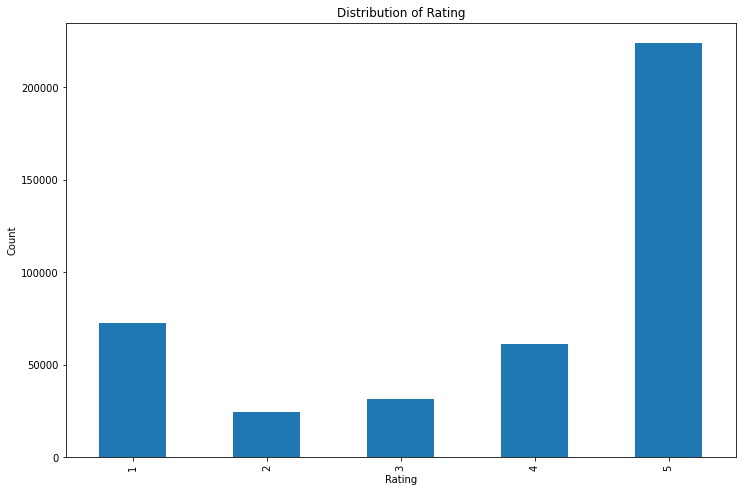

In [10]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

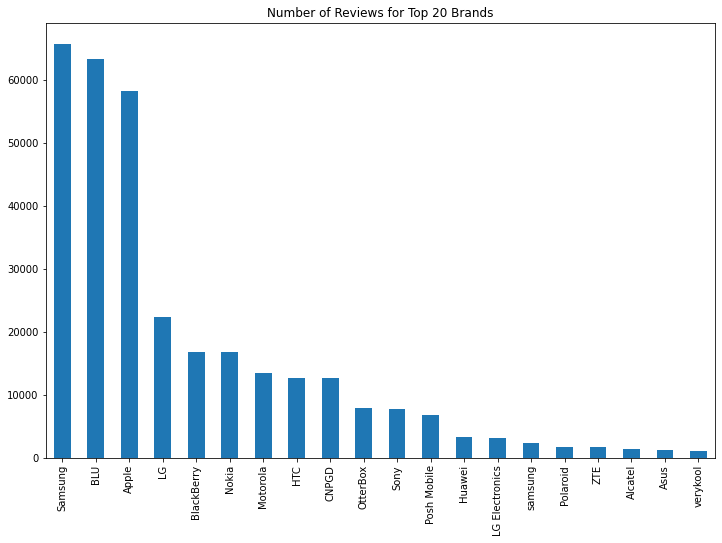

In [11]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

In [14]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 good product and fast shipping. thank you.


In [32]:
def data_clean( rev, remove_stopwords=True): 
    

    new_text = re.sub("[^a-zA-Z]"," ", rev)
   
    words = new_text.lower().split()
    
    if remove_stopwords:
        sts = set(stopwords.words("english"))
        words = [w for w in words if not w in sts]
    ary=[]
    eng_stemmer = english_stemmer 
    for word in words:
        ary.append(eng_stemmer.stem(word))

    
    return(ary)

In [37]:
english_stemmer=nltk.stem.SnowballStemmer('english')
from bs4 import BeautifulSoup  
import re
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(" ".join(data_clean(d)))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(" ".join(data_clean(d)))

Show a cleaned review in the training set : 
 good product fast ship thank


In [39]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

27715 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['good', 'product', 'fast', 'ship', 'thank']


In [40]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 2916 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['phone', 'work', 'great', 'use', 'good', 'one', 'like', 'love', 'screen', 'get']


In [41]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [42]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


/home/ym154/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
Training set : 27799 feature vectors with 300 dimensions
Validation set : 3089 feature vectors with 300 dimensions


In [43]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (2916, 300)
/home/ym154/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [44]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (27799, 100)
X_test shape: (3089, 100)
y_train shape: (27799, 2)
y_test shape: (3089, 2)


In [45]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         874800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,094,706
Trainable params: 1,094,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
27799/27799 [==============================] - 276s 10ms/step - loss: 0.2786 - acc: 0.8855
Epoch 2/3
27799/27799 [==============================] - 276s 10ms/step - loss: 0.1617 - acc: 0.9418
Epoch 3/3
3089/3089 [==============================] - 8s 3ms/

In [46]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (2916, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)
